# PUMP IT UP


**Introduction:**
Using the data gathered from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? Predicting one of these three classes based and a smart understanding of which waterpoints will fail, can improve the maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This is also an intermediate-level competition by [DataDriven][1]! All code & support scripts are in [Github Repo][2]

[1]: https://www.drivendata.org/competitions/7/ "Link to Competetion Page"
[2]: https://github.com/msampathkumar/datadriven_pumpit "User Code"

# Imports

In [160]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.tools import game


%matplotlib inline
# %load_ext writeandexecute

plt.style.use('ggplot')
sns.set(color_codes=True)

# seed
np.random.seed(69572)

# import sys
# sys.path = sys.path + ['/Users/sampathkumarm/Desktop/devbox/Sam-DS/Kaggle/datadriven']

import scripts

import imp
imp.reload(scripts)

from scripts.sam_value_counts import sam_dataframe_cols_value_count_analysis, sam_dataframe_markup_value_counts
from scripts.sam_confusion_matrix import sam_plot_confusion_matrix, sam_confusion_maxtrix

import sys

from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from markdown import markdown
from IPython.core.display import HTML
from IPython.display import display

@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
    
    def timer_message(self, start_time):
#         print self
        time_diff = (now() - start_time).total_seconds()
        if time_diff < 0.001:
            time_diff = 0
            print('\n<pre>In', time_diff, 'Secs</pre>')
        else:
            print('\n<pre>In', time_diff, 'Secs</pre>')

    @cell_magic
    def timer(self, line, cell):
        import datetime
        now = datetime.datetime.now
        start_time = now()
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
            self.timer_message(start_time)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

# Data Analysis

In [2]:
RAW_X = pd.read_csv('data/traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('data/training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('data/test_set_values.csv', index_col='id')

In [3]:
# proportion of labels  available
RAW_y.status_group.value_counts() / RAW_y.size

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [7]:
def check_shape(*dfs):
    for df in dfs:
        print('Share of Data Frame is', df.shape)

def df_check_stats(*dfs):
    """To print DataFrames Shape & Cols details.

    Input: X, y, TEST_X,..
    """
    stmt = "Data Frame Shape: %1.15s TotColumns: %1.15s ObjectCols: %1.15s"
    for df in dfs:
        df_shape = str(df.shape)
        obj_cols, all_cols = len(df.dtypes[df.dtypes == '0']), len(df.dtypes)
        print(stmt % (df_shape, obj_cols, all_cols))
    return

In [8]:
print('Shape of RAW_X', RAW_X.shape)
print('Shape of RAW_y', RAW_y.shape)
print('Shape of RAW_TEST_X', RAW_TEST_X.shape)

# ('Shape of RAW_X', (59400, 39))
# ('Shape of RAW_y', (59400, 1))
# ('Shape of RAW_TEST_X', (14850, 39))

Shape of RAW_X (59400, 39)
Shape of RAW_y (59400, 1)
Shape of RAW_TEST_X (14850, 39)


In [9]:
for i, col in enumerate(RAW_X.columns):
    print('|%d|%s|%d|' % (i, col, len(RAW_X[col].value_counts())))

|0|amount_tsh|98|
|1|date_recorded|356|
|2|funder|1897|
|3|gps_height|2428|
|4|installer|2145|
|5|longitude|57516|
|6|latitude|57517|
|7|wpt_name|37400|
|8|num_private|65|
|9|basin|9|
|10|subvillage|19287|
|11|region|21|
|12|region_code|27|
|13|district_code|20|
|14|lga|125|
|15|ward|2092|
|16|population|1049|
|17|public_meeting|2|
|18|recorded_by|1|
|19|scheme_management|12|
|20|scheme_name|2696|
|21|permit|2|
|22|construction_year|55|
|23|extraction_type|18|
|24|extraction_type_group|13|
|25|extraction_type_class|7|
|26|management|12|
|27|management_group|5|
|28|payment|7|
|29|payment_type|7|
|30|water_quality|8|
|31|quality_group|6|
|32|quantity|5|
|33|quantity_group|5|
|34|source|10|
|35|source_type|7|
|36|source_class|3|
|37|waterpoint_type|7|
|38|waterpoint_type_group|6|


In [10]:
# integer colums
cols_ints = '''amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year'''.splitlines()

# bool
cols_bool = 'public_meeting permit'.split()

# date
cols_date = ['date_recorded']

print('INT COlS: ', len(cols_ints))
print('BOOL COLS:', len(cols_bool))
print('Date COLS:', len(cols_date))

INT COlS:  9
BOOL COLS: 2
Date COLS: 1


In [12]:
def df_check_stats(*dfs):
    for df in dfs:
        df_shape = str(df.shape)
        obj_cols, all_cols = len(df.dtypes[X.dtypes == '0']), len(df.dtypes)
        print("Share of Data Frame: %1.15s All Columns: %1.15s Object Cols: %1.15s" % (df_shape, obj_cols, all_cols))

In [13]:
def show_object_dtypes(df,others=True):
    dtype = object
    if others:
        return df.dtypes[df.dtypes == dtype]
    else:
        return df.dtypes[df.dtypes != dtype]

In [88]:
show_object_dtypes(RAW_TEST_X, True)

funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
recorded_by              object
scheme_management        object
scheme_name              object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [89]:
show_object_dtypes(RAW_TEST_X, False)

amount_tsh               float64
date_recorded              int64
gps_height                 int64
longitude                float64
latitude                 float64
num_private                int64
region_code                int64
district_code              int64
population                 int64
public_meeting             int64
permit                     int64
construction_year          int64
date_recorded_weekday      int64
date_recorded_date         int64
date_recorded_month        int64
date_recorded_year         int64
dtype: object

### cols_values_counts_dataframe

As we can see in above *describe* output, we seem to have lots of categorical values so let start exploring them a bit.

Lets start taking into believe everything is a Categorical Columns and check their data

In [90]:
columns = RAW_X.columns
values_counts_bag = [len(RAW_X[column].value_counts()) for column in columns]

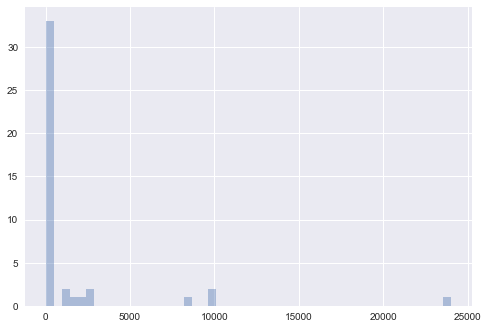

In [91]:
_ = sns.distplot(values_counts_bag, hist=True, kde=False,)

** Example of how np-log transforms data**

    >>> np.log([0.001, 0.01, 0.1, 1, 10, 100, 1000])

    array([-6.90775528, -4.60517019, -2.30258509,  0.        ,  2.30258509,
            4.60517019,  6.90775528])

As you can see in np-log example, we can learn that when a list of values vary significantly(exponentially) then their logarithms moves linearly. As we(I) feel comfortable in studying linear plot and linear information, we did a np.log to values counts.

In [92]:
cols_values_counts_dataframe = pd.DataFrame(np.log(values_counts_bag), index=columns, columns=['Value Counts'])

Values Counts: [98, 329, 1752, 2428, 2004, 9728, 9670, 24033, 63, 9, 8461, 21, 27, 20, 124, 977, 1034, 3, 1, 12, 2678, 3, 55, 18, 13, 7, 12, 5, 7, 7, 8, 6, 5, 5, 10, 7, 3, 7, 6, 7, 31, 12, 5]

Log of Values Counts: [[  4.58496748   5.79605775   7.46851327   7.79482315   7.60290046
    9.1827636    9.17678359  10.08718316   4.14313473   2.19722458
    9.04322265   3.04452244   3.29583687   2.99573227   4.82028157
    6.88448665   6.94119006   1.09861229   0.           2.48490665
    7.89282553   1.09861229   4.00733319   2.89037176   2.56494936
    1.94591015   2.48490665   1.60943791   1.94591015   1.94591015
    2.07944154   1.79175947   1.60943791   1.60943791   2.30258509
    1.94591015   1.09861229   1.94591015   1.79175947   1.94591015
    3.4339872    2.48490665   1.60943791]]


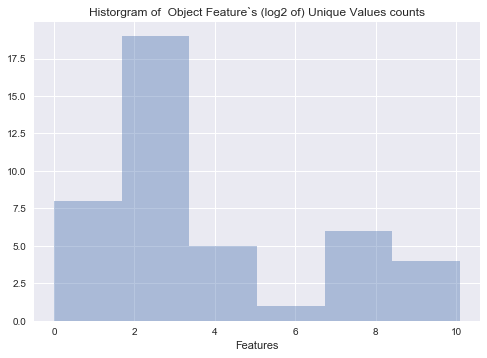

In [93]:
print('Values Counts:', values_counts_bag)

print('\nLog of Values Counts:', cols_values_counts_dataframe.T.values)

_ = sns.distplot(cols_values_counts_dataframe.T.values, hist=True, kde=False,)

plt.title('Historgram of  Object Feature`s (log2 of) Unique Values counts')
plt.xlabel('Features')

We seem to have some special categories where value counts are high.


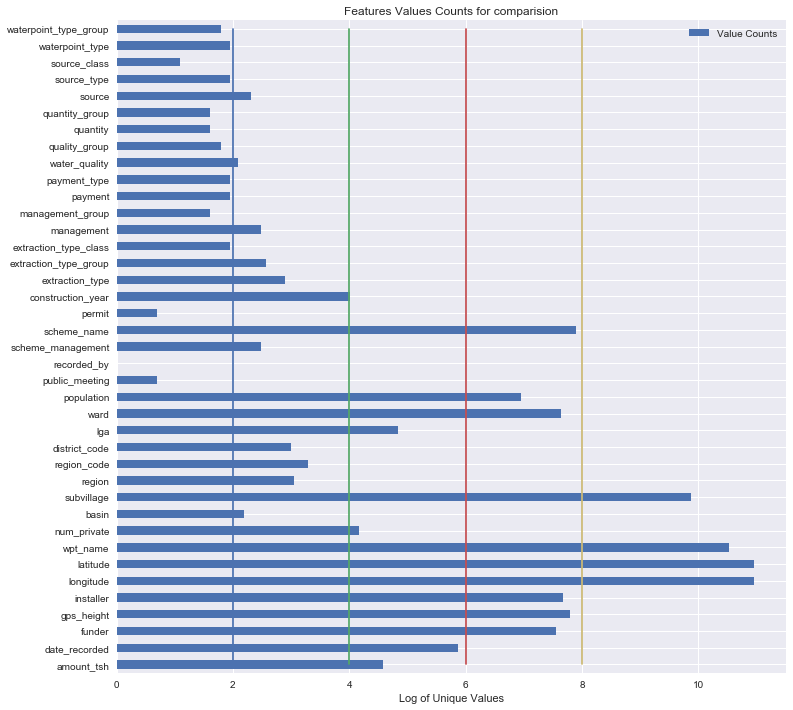

In [41]:
cols_values_counts_dataframe.plot(kind='barh', figsize=(12, 12))
_ = plt.plot((2, 2), (0, 38))
_ = plt.plot((4, 4), (0, 38), '-g')
_ = plt.plot((6, 6), (0, 38), '-r')
_ = plt.plot((8, 8), (0, 38), '-y')
print('We seem to have some special categories where value counts are high.')

plt.title('Features Values Counts for comparision')
plt.xlabel ('Log of Unique Values')

Columns Value Counts Limit: 55 provided(or default)-input param
Columns Available for Plot: 24 provided(or default)-input param


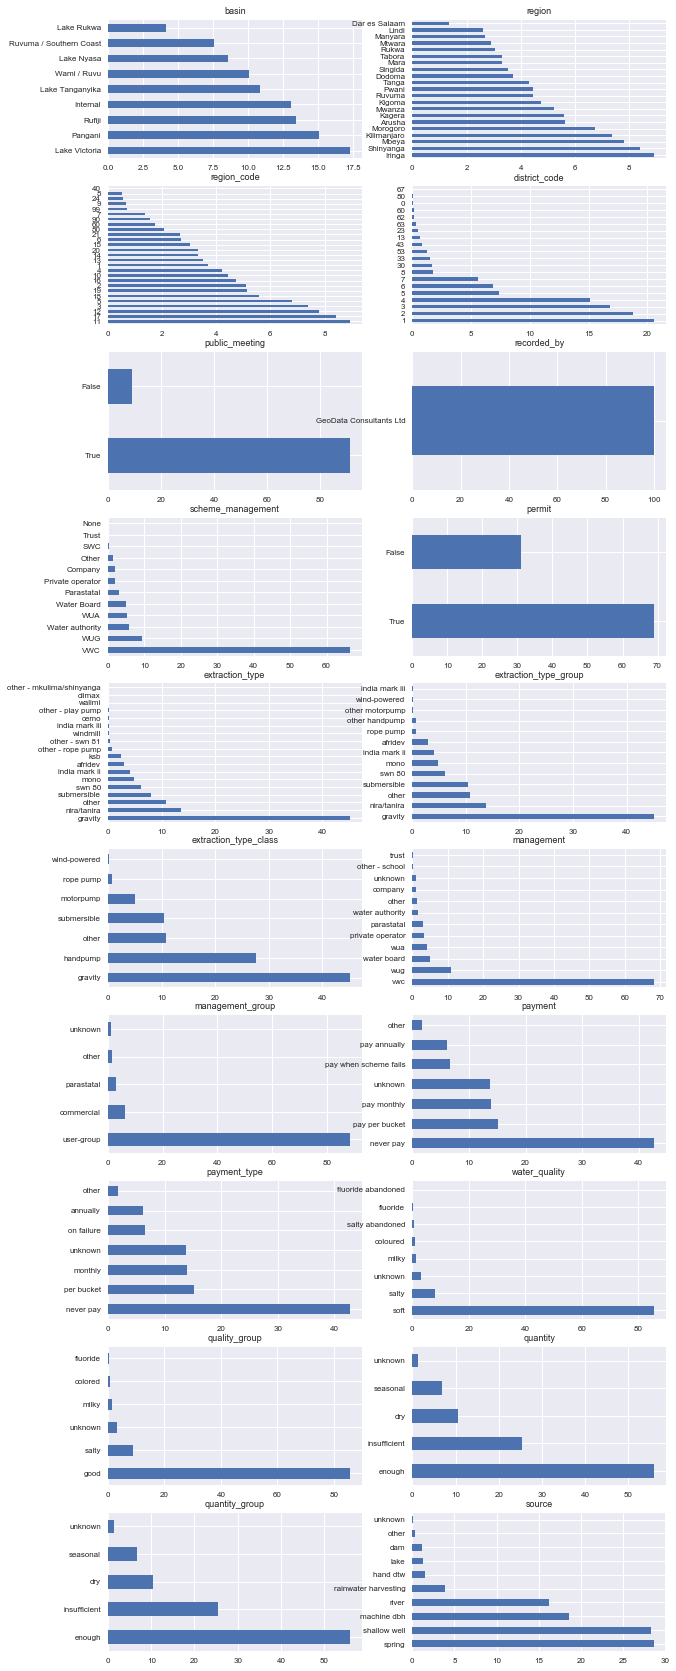

In [42]:
sam_dataframe_cols_value_count_analysis(RAW_X)

** Checking rest of the columns**

In [43]:
cols_value_count_limit_fraction = 0.01
cols_value_count_limit_log_value = np.log(RAW_X.shape[0] * cols_value_count_limit_fraction)


print('Total Number of Records:', RAW_X.shape[0], '- Log val is:', np.log(RAW_X.shape[0]))
print('%s percent of Number of Records:' % (cols_value_count_limit_fraction * 100),\
      RAW_X.shape[0] * cols_value_count_limit_fraction,\
      ' - Log val is:',  cols_value_count_limit_log_value)

Total Number of Records: 59400 - Log val is: 10.9920495054
1.0 percent of Number of Records: 594.0  - Log val is: 6.38687931936


### cols_categorical_check

Here in this project, `cols_categorical_check` refers to list of columns for which caution check is considered. Reason for this check is, we would need more data to explain other columns & target cols with respect to it.

Lets consider these columns with more 5% of values as non categorical values and since our problem statement is choosing which category, we will try to minimise the category and see how our performance changes(improves or not)

To begin we will consider that those categories with more than `cols_value_count_limit_fraction` percentage as the upper limit allowed. Any column with other data will pruged to become some to other information

In [44]:
cols_non_categorical = show_object_dtypes(RAW_X, True).index.tolist()

cols_date_numerics = show_object_dtypes(RAW_X, True).index.tolist()

In [45]:
cols_categorical_check = []

for col, vc in cols_values_counts_dataframe.iterrows():
    if col in cols_non_categorical:
        if float(vc) > cols_value_count_limit_log_value:
            cols_categorical_check.append(col)

print('Columns we need to moderate are:', cols_categorical_check)

Columns we need to moderate are: ['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name']


All `cols_date_numerics`, are date & other numeric data which can be made into buckets or reducing precision. Thus we can bound number of categories in data as the more variety of data we have, we need more information specific to each category which all might end with **curse of dimensionality**.

During pre-processing states we shall do following
TODO
* limiting check experiments on our **`cols_date_numerics`** & **`cols_categorical_check`** to be under **`cols_value_count_limit_fraction`**

# Observations & TODO

* Most of the data seems categorical

* Need to check **cols_date_numerics**(TODO1)
    * we shall convert date -> day, month, year, weekday, total_no_of_day_from_reference_point. These splits for two reasons.
        * Reason1: It might be possible that in some location all specific set of complaints are registered on a start/mid/at end of the month. It might also be possible that they are registered on every Monday or so.
        * Reason2: Taking as much information as possible.
* Need to check **cols_categorical_check**(TODO2) 
    * longitutude & latitude seem to hold (0,0) instead of NULL which is acting as outlier for now

* Following pairs looks closesly related - cleanup (TODO3)
    * quantity & quantity_group
    * quality_group & water_quality
    * extraction_type, extraction_type_class & extraction_type_group

* Other - cleanup (TODO4)
    * recorded_by, seems to hold only a single value
    * population & amount_tsh, values are for some given as zero

# Data Processing

## Generic Transformations
** Num/Bool Tranformations **

* date_recorded to Int
* public_meeting to Int
* permit to Int
* longitude to Float(less precision)
* latitude to Float(less precision)

Precision Description of Longititude and Latitude is available here at below [link](http://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)





In [94]:
# Reloading the data

RAW_X = pd.read_csv('data/traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('data/training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('data/test_set_values.csv', index_col='id')

### Int Transformations

In [95]:
import datetime

strptime = datetime.datetime.strptime

DATE_FORMAT = "%Y-%m-%d"
REFERENCE_DATE_POINT = strptime('2000-01-01', DATE_FORMAT)

if RAW_X.date_recorded.dtype == 'O':

    # convert it to datetime format
    f = lambda x: strptime(str(x), DATE_FORMAT)
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

    # week day
    f = lambda x: x.weekday()
    RAW_X['date_recorded_weekday'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_weekday'] = RAW_TEST_X.date_recorded.apply(f)

    # date
    f = lambda x: x.day
    RAW_X['date_recorded_date'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_date'] = RAW_TEST_X.date_recorded.apply(f)

    # month
    f = lambda x: x.month
    RAW_X['date_recorded_month'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_month'] = RAW_TEST_X.date_recorded.apply(f)

    # year
    f = lambda x: x.year
    RAW_X['date_recorded_year'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_year'] = RAW_TEST_X.date_recorded.apply(f)

    # total days
    f = lambda x: (x - REFERENCE_DATE_POINT).days
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

In [96]:
# Longitude & Latitude -- zero values fix

# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'latitude'][RAW_X.latitude < -1.0].values)

if not RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'].empty:
    RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X.latitude >= -1.0, u'latitude'] = _


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'longitude'][RAW_X[u'longitude'] > 1.0].values)

if not RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'].empty:
    RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X[u'longitude'] <= 1.0, u'longitude'] = _

In [97]:
def f(x):
    if x is True:
        return 1
    elif x is False:
        return 2
    else:
        return 3


if (RAW_X.public_meeting.dtype != 'bool') and (RAW_X.permit.dtype != 'bool'):

    # public_meeting
    RAW_X.public_meeting = RAW_X.public_meeting.apply(f)
    RAW_TEST_X.public_meeting = RAW_TEST_X.public_meeting.apply(f)

    # permit
    RAW_X.permit = RAW_X.permit.apply(f)
    RAW_TEST_X.permit = RAW_TEST_X.permit.apply(f)

print('Dtype of public_meetings & permit:',RAW_X.public_meeting.dtype, RAW_X.permit.dtype)
print('')
# checking
if list(RAW_TEST_X.dtypes[RAW_TEST_X.dtypes != RAW_X.dtypes]):
    raise Exception('RAW_X.dtypes and RAW_TEST_X.dtypes are not in Sync')
else:
    print('All in Good Shape')

Dtype of public_meetings & permit: int64 int64

All in Good Shape


In [98]:
show_object_dtypes(RAW_X, True)

funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
recorded_by              object
scheme_management        object
scheme_name              object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [99]:
show_object_dtypes(RAW_X, False)

amount_tsh               float64
date_recorded              int64
gps_height                 int64
longitude                float64
latitude                 float64
num_private                int64
region_code                int64
district_code              int64
population                 int64
public_meeting             int64
permit                     int64
construction_year          int64
date_recorded_weekday      int64
date_recorded_date         int64
date_recorded_month        int64
date_recorded_year         int64
dtype: object

In [100]:
# Reducing geo location precision to 11 meters
LONG_LAT_PRECISION = 0.001

# Reducing Precision of Lat.
if RAW_X.longitude.mean() < 50:
    RAW_X.longitude = RAW_X.longitude // LONG_LAT_PRECISION
    RAW_X.latitude = RAW_X.latitude // LONG_LAT_PRECISION
    RAW_TEST_X.longitude = RAW_TEST_X.longitude // LONG_LAT_PRECISION
    RAW_TEST_X.latitude = RAW_TEST_X.latitude // LONG_LAT_PRECISION

### Text Data Tranformations

For **cols_categorical_check**, we are going to basic clean action like, lower and upper case issue. Clearning of non ascii values.

In [101]:
def text_transformation(name):
    """Cleanup basic text issue in name(input).
    
    Removes text capitalisation, case, space and other non text ascii charecters
        except space.
    """
    if name:
        name = name.lower().strip()
        name = ''.join([i if 96 < ord(i) < 128 else ' ' for i in name])
        if 'and' in name:
            name = name.replace('and', ' ')

        # clear double space
        while '  ' in name:
            name = name.replace('  ', ' ')
        return name.strip()
    return ''

In [102]:
# saving transformed data
pickle.dump(obj=RAW_X, file=open('tmp\clean_X.pkl', 'wb'))
pickle.dump(RAW_TEST_X, open('tmp\clean_TEST_X.pkl', 'wb'))
# pickle.dump(y, open('tmp\y.pkl', 'wb'))

TEST_X, X = RAW_TEST_X, RAW_X

## Custom Labeler

Loading Custom Labeler is for the the purpose of reducing categories varieties by ignoring groups with lower frequencies and covering 80%(default) of the original data.

In [103]:
from collections import defaultdict
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from scripts import sam_custom_labeler

CUST_CATEGORY_LABELER = sam_custom_labeler.CUST_CATEGORY_LABELER

* funder:
    * 100.0 percentage of DATA coverage mean, 1881 (in number) groups
    * 97.0 percentage of DATA coverage mean, 592 (in number) groups ##
    * 90.5 percentage of DATA coverage mean, 237 (in number) groups
* installer:
    * 100.0 percentage of DATA coverage mean, 1867 (in number) groups
    * 97.0 percentage of DATA coverage mean, 599 (in number) groups ##

* wpt_name:
    * 80.0 percentage of DATA coverage mean, 24838 (in number) groups ##

* subvillage:
    * 80.5 percentage of DATA coverage mean, 8715 (in number) groups ##
    * 83.0 percentage of DATA coverage mean, 9458 (in number) groups
* ward:
    * 80.0 percentage of DATA coverage mean, 998 (in number) groups ##
    * 91.5 percentage of DATA coverage mean, 1397 (in number) groups
    * 100.0 percentage of DATA coverage mean, 2093 (in number) groups
* scheme_name:
    * 100.0 percentage of DATA coverage mean, 2486 (in number) groups
    * 91.5 percentage of DATA coverage mean, 870 (in number) groups
    * 80.5 percentage of DATA coverage mean, 363 (in number) groups
    * 85.0 percentage of DATA coverage mean, 524 (in number) groups ##    
** NOTE **:
    Marked with double hashes are the selected values for coverage


In [104]:
##################################
######### IMPLEMENT ##############
#################################

if 'custom_labler' not in dir():
    custom_labler = defaultdict(CUST_CATEGORY_LABELER)
    tmp = { 'funder': 97,
      'installer': 97,
      'wpt_name': 80,
      'subvillage': 80,
      'ward': 80,
      'scheme_name': 85
      }

    for col, limit  in tmp.items():
        labler = custom_labler[col]
        labler.DATA_COVERAGE_LIMIT = limit
        labler.fit(X[col])
        print('')
        print('-' * 15, col.upper())

    #     custom_labler[col].check_data_coverage(limit)
        RAW_X[col] = labler.transform()
else:
    print('"custom_labler" seems is already defined, please check')
    
print(RAW_X.shape, RAW_TEST_X.shape, all(RAW_X.columns == RAW_TEST_X.columns))

"custom_labler" seems is already defined, please check
(59400, 43) (14850, 43) True


## Label Encoder

Label Encoder with DefaultDict for quick data transformation
http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [105]:
from collections import defaultdict
from sklearn import preprocessing

In [106]:
print(RAW_X.shape, RAW_TEST_X.shape)

(59400, 43) (14850, 43)


In [107]:
RAW_X.dtypes[RAW_X.dtypes == 'O'].index.tolist()

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [108]:
RAW_X.dropna(inplace=True)

In [109]:
d = defaultdict(preprocessing.LabelEncoder)

tmp = RAW_X.dtypes[RAW_X.dtypes == 'O'].index.tolist()

RAW_X[tmp] = RAW_X[tmp].fillna('Other')
RAW_TEST_X[tmp] = RAW_TEST_X[tmp].fillna('Other')

# Labels Fit
sam = pd.concat([RAW_X, RAW_TEST_X]).apply(lambda x: d[x.name].fit(x))

# Labels Transform - Training Data
X = RAW_X.apply(lambda x: d[x.name].transform(x))
TEST_X = RAW_TEST_X.apply(lambda x: d[x.name].transform(x))

le = preprocessing.LabelEncoder().fit(RAW_y[u'status_group'])
y = le.transform(RAW_y[u'status_group'])

In [110]:
show_object_dtypes(RAW_X, True)

funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
recorded_by              object
scheme_management        object
scheme_name              object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [111]:
show_object_dtypes(X, True)

Series([], dtype: object)

## Pickle

** Pickle Save **

In [112]:
# saving transformed data
pickle.dump(X, open('tmp\processed_X.pkl', 'wb'))
pickle.dump(TEST_X, open('tmp\processed_TEST_X.pkl', 'wb'))
pickle.dump(y, open('tmp\processed_y.pkl', 'wb'))

# saving label transformers
pickle.dump(d, open('tmp\d.pkl', 'wb'))
pickle.dump(le, open('tmp\le.pkl', 'wb'))

# Feature Selection


In [113]:
X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))
y = pickle.load(open('tmp\processed_y.pkl', 'rb'))

# # Load this when you are about to do text transformation and submission
# d = pickle.load(open('tmp\d.pkl'))
# le = pickle.load(open('tmp\le.pkl'))

print(X.shape, y.shape, y[:5])

(28715, 43) (59400,) [0 0 0 2 0]


### Variance Threshold

To remove all features that are either one or zero (on or off) in more than 80% of the samples.

http://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance

http://stackoverflow.com/questions/29298973/removing-features-with-low-variance-scikit-learn/34850639#34850639

In [114]:
X.dtypes[X.dtypes != np.int64]

Series([], dtype: object)

In [115]:
from scripts.sam_variance_check import get_low_variance_columns

In [116]:
X, removed_features, ranking_variance_thresholds = get_low_variance_columns(dframe=X,
                                                                            threshold=(0.85 * (1 - 0.85)),
                                                                            autoremove=True)

print('\nLow Variance Columns', removed_features)

if removed_features:
    TEST_X.drop(removed_features, axis=1, inplace=True)
    print('cleanup completed!')

Finding low-variance features.
Found 1 low-variance columns.
                
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.

Low Variance Columns ['recorded_by']
cleanup completed!


In [117]:
print('Shape of X is', X.shape)
print('Shape of TEST_X is', TEST_X.shape)

Shape of X is (28715, 42)
Shape of TEST_X is (14850, 42)


### Select K Best

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif


Random Forest Classifier score: RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)
* chi2 0.81225589225589223
*  f_classic 0.81138047138047142
* mutual_info_classif 0.81037037037037041

In [118]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [119]:
kbest_cols = len(X.columns) -5

print(('Shape of X:', X.shape))
for fns in [chi2, f_classif, mutual_info_classif]:
    print((str(fns.__name__),game(SelectKBest(score_func=fns, k=kbest_cols).fit(X, y).transform(X), y, model='rf')))

for fns in [chi2, f_classif, mutual_info_classif]:
    print((str(fns.__name__),game(SelectKBest(score_func=fns, k=kbest_cols).fit(X, y).transform(X), y, model='gbt')))

('Shape of X:', (28715, 42))


NameError: name 'game' is not defined

In [120]:
print('''
('Shape of X:', (59400, 42))

('chi2', (0.98478114478114476, 0.79548821548821547))
('f_classif', (0.98381593714927051, 0.79569023569023567))
('mutual_info_classif', (0.98505050505050507, 0.79919191919191923))

('chi2', (0.75800224466891131, 0.75535353535353533))
('f_classif', (0.75755331088664424, 0.75575757575757574))
('mutual_info_classif', (0.75795735129068464, 0.75515151515151513))
'''.replace(', (', ', ').replace('))', ')').replace('(', '|').replace(')', '|').replace(', ', '|'))


|'Shape of X:'|59400|42|

|'chi2'|0.98478114478114476|0.79548821548821547|
|'f_classif'|0.98381593714927051|0.79569023569023567|
|'mutual_info_classif'|0.98505050505050507|0.79919191919191923|

|'chi2'|0.75800224466891131|0.75535353535353533|
|'f_classif'|0.75755331088664424|0.75575757575757574|
|'mutual_info_classif'|0.75795735129068464|0.75515151515151513|



In [121]:
bag  = [
# {'cols': 1, 'test': 0.5511111111111111, 'train': 0.5545679012345679},
#  {'cols': 9, 'test': 0.650976430976431, 'train': 0.658294051627385},
 {'cols': 17, 'test': 0.7022895622895623, 'train': 0.7092480359147025},
 {'cols': 25, 'test': 0.7517171717171717, 'train': 0.7534455667789001},
 {'cols': 25, 'test': 0.75171717171717167, 'train': 0.75344556677890007},
 {'cols': 28, 'test': 0.7531986531986532, 'train': 0.75537598204264866},
 {'cols': 31, 'test': 0.75346801346801351, 'train': 0.7551290684624018},
 {'cols': 33, 'test': 0.7545454545454545, 'train': 0.7562738496071829},
 {'cols': 34, 'test': 0.75535353535353533, 'train': 0.75658810325476988},
 {'cols': 35, 'test': 0.75542087542087544, 'train': 0.75665544332210999},
 {'cols': 36, 'test': 0.75427609427609432, 'train': 0.75586980920314251},
 {'cols': 37, 'test': 0.75535353535353533, 'train': 0.75800224466891131},
 {'cols': 38, 'test': 0.75582491582491584, 'train': 0.75797979797979798},
 {'cols': 39, 'test': 0.75589225589225584, 'train': 0.75797979797979798}]

In [123]:

for kbest_cols in range(18, 25):
# for kbest_cols in range(23, 33, 2):
# for kbest_cols in range(26, 29):
    fit = SelectKBest(score_func=chi2, k=kbest_cols).fit(X, y)
    cols_names = X.columns
    kbest_selected_cols =  [_ for _ in cols_names[:kbest_cols]]

    kbest_X = pd.DataFrame(fit.transform(X.copy()))
    kbest_TEST_X = pd.DataFrame(fit.transform(TEST_X.copy()))
#     kbest_X.columns = kbest_selected_cols
#     kbest_TEST_X.columns = kbest_selected_cols

    # print('Before KBest', X.shape, TEST_X.shape, len(y))
    # print('After KBest', kbest_X.shape, kbest_TEST_X.shape, len(y))

    train_score, test_score = game(kbest_X, y, model='gbt')
    bag.append({'cols': kbest_cols, 'train': train_score, 'test': test_score})

# print(', '.join(kbest_selected_cols).upper())

bag

ValueError: Found input variables with inconsistent numbers of samples: [28715, 59400]

In [124]:
# sorted(bag, key=lambda x : x['cols'])
bag  = [
# {'cols': 1, 'test': 0.5511111111111111, 'train': 0.5545679012345679},
#  {'cols': 9, 'test': 0.650976430976431, 'train': 0.658294051627385},
 {'cols': 17, 'test': 0.7022895622895623, 'train': 0.7092480359147025},
 {'cols': 25, 'test': 0.7517171717171717, 'train': 0.7534455667789001},
 {'cols': 28, 'test': 0.7531986531986532, 'train': 0.75537598204264866},
 {'cols': 31, 'test': 0.75346801346801351, 'train': 0.7551290684624018},
 {'cols': 33, 'test': 0.7545454545454545, 'train': 0.7562738496071829},
 {'cols': 34, 'test': 0.75535353535353533, 'train': 0.75658810325476988},
 {'cols': 35, 'test': 0.75542087542087544, 'train': 0.75665544332210999},
 {'cols': 36, 'test': 0.75427609427609432, 'train': 0.75586980920314251},
 {'cols': 37, 'test': 0.75535353535353533, 'train': 0.75800224466891131},
 {'cols': 38, 'test': 0.75582491582491584, 'train': 0.75797979797979798},
 {'cols': 39, 'test': 0.75589225589225584, 'train': 0.75797979797979798},
 {'cols': 18, 'test': 0.70430976430976433, 'train': 0.70985409652076314},
 {'cols': 19, 'test': 0.70430976430976433, 'train': 0.70985409652076314},
 {'cols': 20, 'test': 0.70484848484848484, 'train': 0.70904601571268233},
 {'cols': 21, 'test': 0.70397306397306403, 'train': 0.71160493827160498},
 {'cols': 22, 'test': 0.70801346801346798, 'train': 0.71331088664421993},
 {'cols': 23, 'test': 0.75077441077441076, 'train': 0.75173961840628511},
 {'cols': 24, 'test': 0.75077441077441076, 'train': 0.75173961840628511}]

bag = pd.DataFrame(bag)

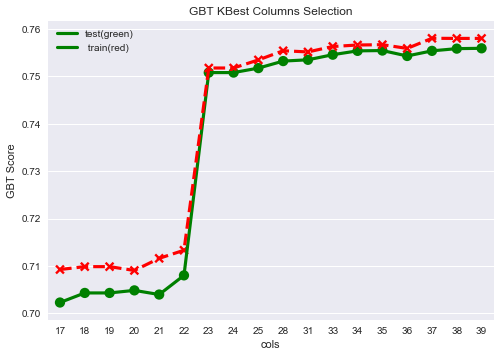

In [126]:
sns.pointplot(x='cols', y='test', data=bag, color='green')
sns.pointplot(x='cols', y='train', data=bag, color='red', markers="x", linestyles='--')
plt.title('GBT KBest Columns Selection')
plt.legend(['test(green)',' train(red)'], )
plt.ylabel('GBT Score')

** kbest conclusion **:

Best selected columns
```
AMOUNT_TSH, DATE_RECORDED, FUNDER, GPS_HEIGHT, INSTALLER, LONGITUDE, LATITUDE, NUM_PRIVATE, BASIN, SUBVILLAGE, REGION, REGION_CODE, DISTRICT_CODE, LGA, WARD, POPULATION, PUBLIC_MEETING, SCHEME_MANAGEMENT, SCHEME_NAME, PERMIT, CONSTRUCTION_YEAR, EXTRACTION_TYPE, EXTRACTION_TYPE_GROUP, EXTRACTION_TYPE_CLASS, MANAGEMENT, MANAGEMENT_GROUP, PAYMENT, PAYMENT_TYPE
```

``` Python
# results of previous runs
[{'cols': 1, 'test': 0.52659932659932662, 'train': 0.57483726150392822},
 {'cols': 5, 'test': 0.68962962962962959, 'train': 0.94240179573512906},
 {'cols': 9, 'test': 0.7211447811447812, 'train': 0.97638608305274976},
 {'cols': 13, 'test': 0.75380471380471381, 'train': 0.97955106621773291},
 {'cols': 17, 'test': 0.76134680134680133, 'train': 0.98071829405162736},
 {'cols': 21, 'test': 0.76511784511784509, 'train': 0.98076318742985413},
 {'cols': 25, 'test': 0.80033670033670035, 'train': 0.98316498316498313},
 {'cols': 29, 'test': 0.80053872053872055, 'train': 0.98379349046015707},
 {'cols': 33, 'test': 0.80040404040404045, 'train': 0.98390572390572395},
 {'cols': 37, 'test': 0.79993265993265994, 'train': 0.98341189674523011}]

[{'cols': 23, 'test': 0.7976430976430976, 'train': 0.9836812570145903},
 {'cols': 25, 'test': 0.80033670033670035, 'train': 0.98316498316498313},
 {'cols': 27, 'test': 0.80101010101010106, 'train': 0.9829405162738496},
 {'cols': 29, 'test': 0.80053872053872055, 'train': 0.98379349046015707},
 {'cols': 31, 'test': 0.80000000000000004, 'train': 0.98381593714927051}]

[{'cols': 26, 'test': 0.80309764309764309, 'train': 0.98359147025813698},
 {'cols': 27, 'test': 0.80101010101010106, 'train': 0.9829405162738496},
 {'cols': 28, 'test': 0.80222222222222217, 'train': 0.98334455667789}]
```


As per Okham Razor's rules, we are going to select the simplest and well performing. Luckily, we have got kbest_selected_cols at **26** which is comparitively top performer among other K-selections and also lower than actualy number of columns


In [127]:
kbest_cols = 26

fit = SelectKBest(score_func=chi2, k=kbest_cols).fit(X, y)
cols_names = X.columns
kbest_selected_cols =  [_ for _ in cols_names[:kbest_cols]]

kbest_X = pd.DataFrame(fit.transform(X))
kbest_TEST_X = pd.DataFrame(fit.transform(TEST_X))

ValueError: Found input variables with inconsistent numbers of samples: [28715, 59400]

In [128]:
kbest_X.shape, kbest_TEST_X.shape, y.shape

NameError: name 'kbest_X' is not defined

In [129]:
pickle.dump(kbest_X, open('tmp\kbest_X.pkl', 'wb'))
pickle.dump(kbest_TEST_X, open('tmp\kbest_TEST_X.pkl', 'wb'))
pickle.dump(y, open('tmp\kbest_y.pkl', 'wb'))

NameError: name 'kbest_X' is not defined

In [130]:
pickle.dump(kbest_X, open('tmp\kbest_X.pkl', 'wb'))
pickle.dump(kbest_TEST_X, open('tmp\kbest_TEST_X.pkl', 'wb'))
pickle.dump(y, open('tmp\kbest_y.pkl', 'wb'))

NameError: name 'kbest_X' is not defined

### PCA

In [131]:
!mkdir tmp

mkdir: tmp: File exists


In [132]:
load = 2

if load == 2:
    # this will load kbest
    print('Loading KBest Processed Data')
    X = pickle.load(open('tmp\kbest_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\kbest_TEST_X.pkl', 'rb'))
    y = pickle.load(open('tmp\kbest_y.pkl', 'rb'))
elif load == 1:
    # this will load processed data
    print('Loading Normal Processed Data')
    X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))

# # y = pickle.load(open('tmp\processed_y.pkl'))

Loading KBest Processed Data


FileNotFoundError: [Errno 2] No such file or directory: 'tmp\\kbest_X.pkl'

** PCA **

In [133]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

[ 0.74397839  0.88222015  0.94067576  0.98384049  0.99016793  0.99431116
  0.99692119  0.9989614   0.99961539  0.99990872  0.99998517  0.99999425
  0.99999661  0.99999813  0.99999881]



NameError: name 'game' is not defined

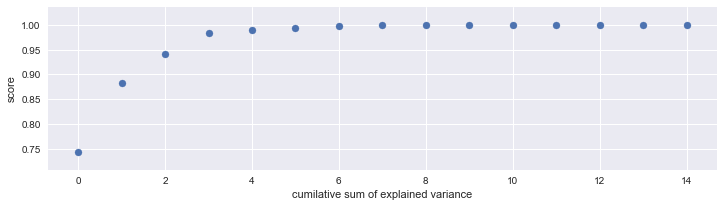

In [134]:
# feature extraction
pca = PCA(n_components=15)
fit = pca.fit(X)

plt.figure(figsize=(12, 3))

_ = plt.scatter(range(len(fit.explained_variance_ratio_)), fit.explained_variance_ratio_.cumsum())

_ = plt.xlabel('cumilative sum of explained variance')
_ = plt.ylabel('score')


print(fit.explained_variance_ratio_.cumsum())
print()
print(('Score', game(pca.transform(X), y, 'gbt')))


# (0.97580246913580249, 0.60511784511784517) # KBest dataset
# (0.97564534231200895, 0.60552188552188557) # Normal Dataset

In [ ]:
ss = pd.DataFrame(fit.components_)
ss = ss.applymap(lambda x: x if x > 0 else -1 * x)
display(ss.describe().T)

ss.plot(kind='bar', figsize=(125, 10))

In [135]:
# feature extraction
lda = LinearDiscriminantAnalysis(n_components=16)
fit = lda.fit(X, y)

plt.figure(figsize=(12, 3))

_ = plt.scatter (range(len(fit.explained_variance_ratio_)), fit.explained_variance_ratio_.cumsum())

_ = plt.xlabel('cumilative sum of explained variance')
_ = plt.ylabel('score')


print(fit.explained_variance_ratio_.cumsum())

print(('\nScore', game(lda.transform(X), y)))


# (0.97580246913580249, 0.60511784511784517) # KBest dataset
# (0.97564534231200895, 0.60552188552188557) # Normal Dataset

ValueError: Found input variables with inconsistent numbers of samples: [28715, 59400]

In [136]:
ss = pd.DataFrame(fit.coef_)
ss = ss.applymap(lambda x: x if x > 0 else -1 * x)
display(ss.describe().T)

ss.plot(kind='bar', figsize=(125, 10))

AttributeError: 'PCA' object has no attribute 'coef_'

In [137]:
X = pca.transform(X)
TEST_X = pca.transform(TEST_X)

In [138]:
X.shape, TEST_X.shape

((28715, 15), (14850, 15))

** Saving Processed Data **

In [139]:
pickle.dump(X, open('tmp\pca_X.pkl', 'wb'))
pickle.dump(TEST_X, open('tmp\pca_TEST_X.pkl', 'wb'))
# pickle.dump(y, open('tmp\pca_y.pkl', 'wb'))

# Unsupervised Learning

* Unsupervised Learning Exploration(Gaussian Process, Neural Nets)

** Loading Pre-Processed Data **

In [ ]:
load = 3

if load == 1:
    print('Loading PCA Processed Data')
    X = pickle.load(open('tmp\pca_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\pca_TEST_X.pkl', 'rb'))
    print(game(X, y, model='rf'))

elif load == 2:
    # this will load kbest
    print('Loading KBest Processed Data')
    X = pickle.load(open('tmp\kbest_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\kbest_TEST_X.pkl', 'rb'))
    print(game(X, y, model='rf'))
    
elif load == 3:
    # this will load processed data
    print('Loading normal Processed Data')
    X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))
    print(game(X, y, model='rf'))

# # y = pickle.load(open('tmp\processed_y.pkl'))

In [ ]:
print(X.shape, y.shape, TEST_X.shape)

### Gaussian

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

In [ ]:
# For future analysis
GMM_Centers = []

__check_for  = 1000

print ('clusters | score for top 1000')

for i in range(2, 7):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=i, random_state=42)
    clusterer.fit(X)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(X)

    # TODO: Find the cluster centers
    GMM_Centers.append(clusterer.means_)

    # score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])

    print(i, score)
    
# clusters | score for top 1000
# 2 0.484879234998
# 3 0.377180934294
# 4 0.334333476259
# 5 0.29213724894
# 6 0.27643712696

### KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# For future analysis
KMM_Centers = []

# Testing each category
for i in range(2, 7):

    clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
    clusterer.fit(X)

    preds = clusterer.predict(X)

    centers = clusterer.cluster_centers_
    
    KMM_Centers.append(centers)

#     score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])
    print(i, score)
    
# clusters | score for top 1000
# 2 0.502005229628
# 3 0.377168744959
# 4 0.325091546516
# 5 0.303811069492
# 6 0.304265445159

In [ ]:
i = 2

clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
clusterer.fit(X)
preds = clusterer.predict(X)

In [ ]:
score = silhouette_score(X[:__check_for], preds[:__check_for])
print(i, score)

In [ ]:
X = pd.DataFrame(X)
X['new'] = clusterer.predict(X)

In [ ]:
TEST_X = pd.DataFrame(TEST_X)
TEST_X['new'] = clusterer.predict(TEST_X)

In [ ]:
print(X.shape, TEST_X.shape)

# Supervised Learning

* Supervised Learning(GBT Trees, Nearest Neighbours, RF, One-vs-One)

### Test-Train Split

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

load = 2

np.set_printoptions(precision=4)
print('------------------------------------------------')

if load == 1:
    print('Loading PCA Processed Data')
    X = pickle.load(open('tmp\pca_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\pca_TEST_X.pkl', 'rb'))
    y = pickle.load(open('tmp\processed_y.pkl', 'rb'))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    model_rf(X_train, y_train)


elif load == 2:
    # this will load kbest
    print('Loading KBest Processed Data')
    X = pickle.load(open('tmp\kbest_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\kbest_TEST_X.pkl', 'rb'))
    y = pickle.load(open('tmp\processed_y.pkl', 'rb'))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    model_rf(X_train, y_train)

elif load == 3:
    # this will load processed data
    print('Loading normal Processed Data')
    X = pickle.load(open('tmp\processed_X.pkl', 'rb'))
    TEST_X = pickle.load(open('tmp\processed_TEST_X.pkl', 'rb'))
    y = pickle.load(open('tmp\processed_y.pkl', 'rb'))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    model_rf(X_train, y_train)

print('------------------------------------------------')

print(X.shape, y.shape)

import sklearn.metrics as sk_metrics

def check_metric(y_pred, y_test, show_cm=True):
    if show_cm:
        print('------------------------------------------------')
        print(sk_metrics.classification_report(y_pred, y_test))
    print('------------------------------------------------')
    print('AC Score:', sk_metrics.accuracy_score(y_pred, y_test),
          'F1 Score:', sk_metrics.f1_score(y_pred, y_test, average='weighted'))
    


------------------------------------------------
Loading KBest Processed Data


FileNotFoundError: [Errno 2] No such file or directory: 'tmp\\kbest_X.pkl'

### GBT Trees

In [142]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbt = GradientBoostingClassifier(random_state=192)

clf_gbt = clf_gbt.fit(X_train, y_train)

# metric
y_train_pred = clf_gbt.predict(X_train)
y_pred = clf_gbt.predict(X_test)
print('GradientBoostingClassifier(random_state=192)')
print('----------')
print('Tranining Score')
check_metric(y_train_pred, y_train, show_cm=False)
print('Testing Score')
check_metric(y_pred, y_test, show_cm=False)

NameError: name 'X_train' is not defined

### Nearest Neighbours

In [143]:
from sklearn.neighbors import KNeighborsClassifier

# modelling
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_test, y_test)

# metric
y_train_pred = clf_knn.predict(X_train)
y_pred = clf_knn.predict(X_test)
print('KNeighborsClassifier()')
print('----------')
print('Tranining Score')
check_metric(y_train_pred, y_train, show_cm=False)
print('Testing Score')
check_metric(y_pred, y_test, show_cm=False)

NameError: name 'X_test' is not defined

In [144]:
from sklearn.neighbors import KNeighborsClassifier

### Random Forest

In [145]:
from sklearn.ensemble import RandomForestClassifier



def model_rf(X_train, y_train):
    """
    Random Forest
    """
    clf_rf = RandomForestClassifier(random_state=192)
    clf_rf = clf_rf.fit(X_train, y_train)

    y_pred = clf_rf.predict(X_test)

    # metric
    y_train_pred = clf_rf.predict(X_train)
    y_pred = clf_rf.predict(X_test)
    print('RandomForestClassifier(random_state=192)')
    print('----------')
    print('Tranining Score')
    check_metric(y_train_pred, y_train, show_cm=False)
    print('Testing Score')
    check_metric(y_pred, y_test, show_cm=False)
    
model_rf(X_train, y_train)

NameError: name 'X_train' is not defined

In [146]:
print(list(zip(X.columns, clf_rf.feature_importances_)))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [147]:
X[kbest_selected_cols].size / 40., X[kbest_selected_cols].shape

NameError: name 'kbest_selected_cols' is not defined

In [148]:

# n_estimators=150, criterion='entropy', class_weight="balanced_subsample", 

clf_rf = RandomForestClassifier(random_state=192, n_jobs=-1)
# class_weight="balanced_subsample"/"balanced"
# criterion="gini"/"entropy"

clf_rf = clf_rf.fit(X_train[kbest_selected_cols], y_train)
# pred = clf_rf.predict_proba(X_test)
clf_rf.score(X_test[kbest_selected_cols], y_test)

NameError: name 'X_train' is not defined

## Model selection Evaluation

In [149]:
# metric
for clf in [clf_gbt,
#             clf_knn,
            clf_rf]:
    y_train_pred = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    print(clf)
#     print('----------')
#     print('Training Score')
#     check_metric(y_train_pred, y_train)
    print('----------')
    print('Testing Score')
    check_metric(y_pred, y_test)

NameError: name 'X_train' is not defined

### Multi Class

In [150]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

** One Vs One **

In [151]:
clf_multiclass_rf = OneVsOneClassifier(RandomForestClassifier(
    n_estimators=200,criterion='entropy', class_weight="balanced_subsample",
    random_state=192, n_jobs=-1
))


clf_multiclass_rf = OneVsOneClassifier(RandomForestClassifier(n_estimators=150,
                       criterion='entropy',
                       class_weight="balanced_subsample",
                       n_jobs=-1, random_state=192
))

clf_multiclass_rf = clf_multiclass_rf.fit(X_train, y_train)

print('Classifier:', clf_multiclass_rf)

print('Score:', clf_multiclass_rf.score(X_train, y_train))
# print('Score:', clf_multiclass_rf.score(X_test, y_test))

y_pred = clf_multiclass_rf.predict(X_test)
check_metric(y_pred, y_test)
# Score: 0.999775533109
# Score: 0.813602693603

NameError: name 'X_train' is not defined

In [152]:
# RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1, random_state=192)

** One vs Rest **

In [153]:
clf_multiclass_rf = OneVsRestClassifier(RandomForestClassifier(
    n_estimators=200,criterion='entropy', class_weight="balanced_subsample",
    random_state=192, n_jobs=-1
))

clf_multiclass_rf = clf_multiclass_rf.fit(X_train, y_train)

print('Classifier:', clf_multiclass_rf)
print('Train Score: ', clf_multiclass_rf.score(X_train, y_train))
# print('Test Score:', clf_multiclass_rf.score(X_test, y_test))

y_pred = clf_multiclass_rf.predict(X_test)
check_metric(y_pred, y_test)

NameError: name 'X_train' is not defined

## Multiclass Model Selection

In [154]:
# Random Forest
clf_multiclass1_rf = OneVsOneClassifier(RandomForestClassifier(
    random_state=192, n_jobs=-1
))
clf_multiclass2_rf = OneVsRestClassifier(RandomForestClassifier(
    random_state=192, n_jobs=-1
))

# Gradient Boosting
clf_multiclass1_gb = OneVsOneClassifier(GradientBoostingClassifier(
    random_state=192
))
clf_multiclass2_gb = OneVsRestClassifier(GradientBoostingClassifier(
    random_state=192
))


clf_multiclass1_rf = clf_multiclass1_rf.fit(X_train, y_train)
clf_multiclass2_rf = clf_multiclass2_rf.fit(X_train, y_train)
clf_multiclass1_gb = clf_multiclass1_gb.fit(X_train, y_train)
clf_multiclass2_gb = clf_multiclass2_gb.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [155]:
for clf in [clf_multiclass1_gb, clf_multiclass2_gb, clf_multiclass1_rf, clf_multiclass2_rf]:
    y_train_pred = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    print('---------------------------------------------------------------------------')
    print(clf)
    print('---------------------------------------------------------------------------')
    print('Training Score')
    check_metric(y_train_pred, y_train)
    print('---------------------------------------------------------------------------')
    print('Testing Score')
    check_metric(y_pred, y_test)

NameError: name 'X_train' is not defined

## Parameter tuning


From above analysis we can see that Random Forest CLF performed better than most other and so here we shall optimise it.

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Random Forest

In [157]:
# max_features
np.sqrt(len(X_train.columns)), np.log(len(X_train.columns))

np.log2(len(X_train.columns)), np.sqrt (len(X_train.columns)), len(X_train.columns)

'balanced_subsample balanced'.split(), 'gini entropy'.split()

parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'class_weight': ['balanced_subsample', 'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_features': ['log2', 'auto', 25],
    'random_state': [192]
}

# clf_rf = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1, random_state=192)
# 0.81346801346801345

GS_CV = RandomizedSearchCV(RandomForestClassifier(), parameters)

GS_CV.fit(X, y)

NameError: name 'X_train' is not defined

In [158]:
print(GS_CV.best_params_, GS_CV.best_score_)
# {'n_estimators': 200, 'max_features': 'log2', 'random_state': 192, 'criterion': 'entropy',
#  'class_weight': 'balanced_subsample'} 0.806717171717

cv_results = pd.DataFrame(GS_CV.cv_results_, columns=[u'mean_fit_time', u'mean_score_time', u'mean_test_score',
       u'mean_train_score', u'param_class_weight', u'param_criterion',
       u'param_max_features', u'param_n_estimators', u'params'])

cv_results.head(2)

import seaborn as sns
sns.set(color_codes=True)

np.random.seed(sum(map(ord, "regression")))

NameError: name 'GS_CV' is not defined

In [159]:
ax=plt.figure(figsize=(8,8))
_ = sns.lmplot(x="mean_test_score", y="mean_train_score", hue="param_max_features", data=cv_results)

NameError: name 'cv_results' is not defined


* Checking "clf_rf" RF performance

### GBT

In [ ]:
GradientBoostingClassifier?

In [ ]:
X.shape

In [ ]:
parameters = {
    'n_estimators': range(25, 250, 50),
    'random_state': [192],
    'min_samples_split': range(2, 8, 2),
#     'min_samples_leaf': [.001, .01, .1, .3, .5],
#     'max_depth': range(3, 8)
}

In [ ]:
GS_CV = RandomizedSearchCV(GradientBoostingClassifier(), parameters)

GS_CV.fit(X, y)

In [ ]:
GS_CV.best_params_, GS_CV.best_score_

cv_results = pd.DataFrame(GS_CV.cv_results_, columns=[u'mean_test_score', u'mean_train_score', # two standard
                                                      # here params keys
                                                      u'param_min_samples_split', u'param_n_estimators', u'params'])

sns.pairplot(data=cv_results, x_vars=['mean_test_score', 'mean_train_score'],
             y_vars=['param_min_samples_split', 'param_n_estimators'])

In [ ]:
parameters = {
    'n_estimators': [215, 225, 235,], # 225 best
    'random_state': [192],
    'min_samples_split': [5, 6],
    'min_samples_leaf': [.001, .01, .1, .3, .5],
#     'max_depth': range(3, 8)
}
GS_CV = RandomizedSearchCV(RandomForestClassifier(), parameters)

GS_CV.fit(X, y)

In [ ]:


cv_results = pd.DataFrame(GS_CV.cv_results_, columns=[u'mean_test_score', u'mean_train_score', # two standard
                                                      # here params keys
                                                      u'param_min_samples_leaf',
                                                      u'param_min_samples_split', u'param_n_estimators',
                                                      u'params'])

_ = sns.pairplot(data=cv_results, x_vars=['mean_test_score', 'mean_train_score'],
             y_vars=['param_min_samples_split', 'param_n_estimators', u'param_min_samples_leaf',])


print(GS_CV.best_params_, GS_CV.best_score_)

## XGBOOST

# Submission

**Model Selection**

+ Check for which model is performing best and using it.
+ Check to apply the one-vs-many//one-vs-one wrapper.
+ Check for 'test_train_split' for which X,y to be used for training

In [ ]:
GS_CV.best_params_

In [ ]:
clf_rf = OneVsOneClassifier(RandomForestClassifier(n_estimators=150,
random_state=192,
max_features='log2',
class_weight='balanced_subsample',
criterion='gini'))

print (clf_rf)

clf_rf = clf_rf.fit(X, y)

In [ ]:
# saving the index
test_ids = RAW_TEST_X.index

# predicint the values
predictions = clf_rf.predict(TEST_X)
print(predictions.shape)

# Converting int to its respective Labels
predictions_labels = le.inverse_transform(predictions)

# setting up column name & save file
sub = pd.DataFrame(predictions_labels, columns=['status_group'])
sub.head()
sub.insert(loc=0, column='id', value=test_ids)
sub.reset_index()
sub.to_csv('submit.csv', index=False)
sub.head()

In [ ]:
scores = '''
0.7970
0.786838161735000
0.799663299663
0.803097643097
0.796498316498000
0.699393939394
0.709020068049
0.779259259259000
0.778047138047
0.813468013468000
0.808821548822
'''.strip().splitlines()

scores = map(lambda x: float(x) if x else None, scores)

stages = '''
Benchmark
Algorithmn Selection

KSelect chi2 Test(40+cols)
KSelect Best(26)Cols
KBest Processed Data

PCA Processed Data Score
Normal Processed Data

OneVsOneClassifier
OneVsRestClassifier

Tuning
Result
'''.strip().splitlines()

In [ ]:
print(list(scores)

In [ ]:
plt.plot([0.797, 0.786838161735, 0.799663299663, 0.803097643097,
          0.796498316498, 0.699393939394, 0.709020068049,
          0.779259259259, 0.778047138047, 0.813468013468, 0.808821548822], )

# plt.xticks(range(3), 'a b c'.split())